<a href="https://colab.research.google.com/github/TAUforPython/machinelearning/blob/main/ML%20autogluon%20multimodal%20prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AutoGluon AutoML for Image + Text + Tabular


AutoMM is a deep learning "model zoo" of model zoos. It can automatically build deep learning models that are suitable for multimodal datasets. You will only need to convert the data into the multimodal dataframe format
and AutoMM can predict the values of one column conditioned on the features from the other columns including images, text, and tabular data.

In [1]:
!pip install --quiet autogluon.multimodal


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.5/259.5 kB 11.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 430.0/430.0 kB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.2/68.2 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.2/266.2 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.1/64.1 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import os
import numpy as np
import warnings
warnings.filterwarnings('ignore')
np.random.seed(123)

## Dataset

For demonstration, we use a simplified and subsampled version of [PetFinder dataset](https://www.kaggle.com/c/petfinder-adoption-prediction). The task is to predict the animals' adoption rates based on their adoption profile information. In this simplified version, the adoption speed is grouped into two categories: 0 (slow) and 1 (fast).

To get started, let's download and prepare the dataset.

In [3]:
download_dir = './ag_automm_tutorial'
zip_file = 'https://automl-mm-bench.s3.amazonaws.com/petfinder_for_tutorial.zip'
from autogluon.core.utils.loaders import load_zip
load_zip.unzip(zip_file, unzip_dir=download_dir)

100%|██████████| 18.8M/18.8M [00:00<00:00, 48.1MiB/s]


Next, we will load the CSV files.

In [4]:
import pandas as pd
dataset_path = download_dir + '/petfinder_for_tutorial'
train_data = pd.read_csv(f'{dataset_path}/train.csv', index_col=0)
test_data = pd.read_csv(f'{dataset_path}/test.csv', index_col=0)
label_col = 'AdoptionSpeed'

We need to expand the image paths to load them in training.

In [5]:
image_col = 'Images'
train_data[image_col] = train_data[image_col].apply(lambda ele: ele.split(';')[0]) # Use the first image for a quick tutorial
test_data[image_col] = test_data[image_col].apply(lambda ele: ele.split(';')[0])


def path_expander(path, base_folder):
    path_l = path.split(';')
    return ';'.join([os.path.abspath(os.path.join(base_folder, path)) for path in path_l])

train_data[image_col] = train_data[image_col].apply(lambda ele: path_expander(ele, base_folder=dataset_path))
test_data[image_col] = test_data[image_col].apply(lambda ele: path_expander(ele, base_folder=dataset_path))

train_data[image_col].iloc[0]

'/content/ag_automm_tutorial/petfinder_for_tutorial/images/7d7a39d71-1.jpg'

Each animal's adoption profile includes pictures, a text description, and various tabular features such as age, breed, name, color, and more. Let's look at an example row of data and display the text description and a picture.

In [6]:
example_row = train_data.iloc[2]

example_row

,2
Type,2
Name,Mattie
Age,12
Breed1,266
Breed2,0
Gender,2
Color1,1
Color2,7
Color3,0
MaturitySize,2


In [7]:
example_row['Description']

"I rescued Mattie with a broken leg. After surgery with pin inserted in her leg, she's made a full recovery."

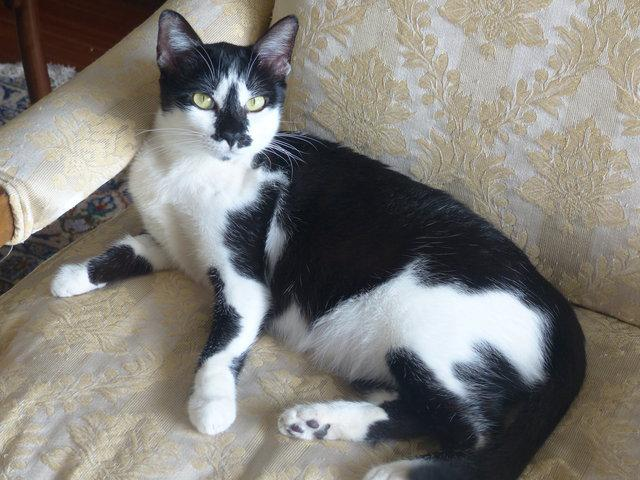

In [8]:
example_image = example_row[image_col]

from IPython.display import Image, display
pil_img = Image(filename=example_image)
display(pil_img)

## Training
Now let's fit the predictor with the training data. Here we set a tight time budget for a quick demo.

https://colab.research.google.com/github/autogluon/autogluon/blob/stable/docs/tutorials/multimodal/advanced_topics/customization.ipynb

In [20]:
import json
from autogluon.multimodal.presets import get_automm_presets

hyperparameters, hyperparameter_tune_kwargs = get_automm_presets(problem_type="default", presets="medium_quality")
print(f"hyperparameters: {json.dumps(hyperparameters, sort_keys=True, indent=4)}")
print(f"hyperparameter_tune_kwargs: {json.dumps(hyperparameter_tune_kwargs, sort_keys=True, indent=4)}")

hyperparameters: {
    "model.document_transformer.checkpoint_name": "microsoft/layoutlmv2-base-uncased",
    "model.hf_text.checkpoint_name": "google/electra-small-discriminator",
    "model.names": [
        "ft_transformer",
        "timm_image",
        "hf_text",
        "document_transformer",
        "fusion_mlp"
    ],
    "model.timm_image.checkpoint_name": "mobilenetv3_large_100",
    "optimization.learning_rate": 0.0004
}
hyperparameter_tune_kwargs: {}


In [21]:
from autogluon.multimodal import MultiModalPredictor
predictor = MultiModalPredictor(label=label_col)

predictor.fit(
    train_data=train_data,
    time_limit=13, # seconds
    hyperparameters=hyperparameters
)

No path specified. Models will be saved in: "AutogluonModels/ag-20250302_133425"
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
Pytorch Version:    2.5.1+cu124
CUDA Version:       CUDA is not available
Memory Avail:       3.32 GB / 12.67 GB (26.2%)
Disk Space Avail:   70.30 GB / 107.72 GB (65.3%)
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [0, 1]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during Predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression', 'quantile'])

AutoMM starts to create your model. ✨✨✨

To track the learning progress, you can open a terminal and launch Tensorboard:
    ```shell
    # Assume you

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/54.2M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/54.2M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/22.1M [00:00<?, ?B/s]

GPU Count: 0
GPU Count to be Used: 0

INFO: GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: 
  | Name              | Type                | Params | Mode 
------------------------------------------------------------------
0 | model             | MultimodalFusionMLP | 21.3 M | train
1 | validation_metric | BinaryAUROC         | 0      | train
2 | loss_func         | CrossEntropyLoss    | 0      | train
------------------------------------------------------------------
21.3 M    Trainable params
0         Non-trainable params
21.3 M    Total params
85.083    Total estimated model params size (MB)
369       Modules in train mode
226       Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO: Time limit reached. Elapsed time is 0:00:14. Signaling Trainer to stop.


Validation: |          | 0/? [00:00<?, ?it/s]

AutoMM has created your model. 🎉🎉🎉

To load the model, use the code below:
    ```python
    from autogluon.multimodal import MultiModalPredictor
    predictor = MultiModalPredictor.load("/content/AutogluonModels/ag-20250302_133425")
    ```

If you are not satisfied with the model, try to increase the training time, 
adjust the hyperparameters (https://auto.gluon.ai/stable/tutorials/multimodal/advanced_topics/customization.html),
or post issues on GitHub (https://github.com/autogluon/autogluon/issues).




Under the hood, AutoMM automatically infers the problem type (classification or regression), detects the data modalities, selects the related models from the multimodal model pools, and trains the selected models. If multiple backbones are available, AutoMM appends a late-fusion model (MLP or transformer) on top of them.


## Evaluation
Then we can evaluate the predictor on the test data.

In [22]:
scores = predictor.evaluate(test_data, metrics=["roc_auc"])
scores

Predicting: |          | 0/? [00:00<?, ?it/s]

{'roc_auc': 0.5800000000000001}

## Prediction
Given a multimodal dataframe without the label column, we can predict the labels.

In [23]:
predictions = predictor.predict(test_data.drop(columns=label_col))
predictions[:5]

Predicting: |          | 0/? [00:00<?, ?it/s]

,AdoptionSpeed
8,0
70,1
82,0
28,0
63,0


For classification tasks, we can get the probabilities of all classes.

In [24]:
probas = predictor.predict_proba(test_data.drop(columns=label_col))
probas[:5]

Predicting: |          | 0/? [00:00<?, ?it/s]

,0,1
8,0.988966,0.011034
70,0.225658,0.774342
82,0.871417,0.128583
28,0.947402,0.052598
63,0.735374,0.264626


Note that calling `.predict_proba()` on one regression task will throw an exception.


## Extract Embeddings

Extracting embeddings can also be useful in many cases, where we want to convert each sample (per row in the dataframe) into an embedding vector.

In [25]:
embeddings = predictor.extract_embedding(test_data.drop(columns=label_col))
embeddings.shape

Predicting: |          | 0/? [00:00<?, ?it/s]

(100, 128)

## Save and Load
It is also convenient to save a predictor and re-load it.

```{warning}

`MultiModalPredictor.load()` uses `pickle` module implicitly, which is known to be insecure. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling. Never load data that could have come from an untrusted source, or that could have been tampered with. **Only load data you trust.**

```

In [ ]:
import uuid

model_path = f"./tmp/{uuid.uuid4().hex}-saved_model"
predictor.save(model_path)
loaded_predictor = MultiModalPredictor.load(model_path)
scores2 = loaded_predictor.evaluate(test_data, metrics=["roc_auc"])
scores2